# Tune RFX parameters to match dataset

In [1]:
from utils import *
import itertools

DEV: cpu


cp: train.py: No such file or directory


In [2]:
# load dataset
N_DS = 50_000 # number of samples in the dataset
# N_DS = 10_000 # number of samples in the dataset

ds = np.load(f'data/sxr_real_ds_gs{GSIZE}_n{N_DS}.npz')
emiss = ds['emiss']
# scale everything so it's in the range [0, 1]
ks = np.max(emiss.reshape(-1, GSIZE*GSIZE), axis=-1).reshape(-1, 1)
vdi = ds['vdi']/ks
vdc = ds['vdc']/ks
vde = ds['vde']/ks
hor = ds['hor']/ks
SXRS = [vdi, vdc, vde, hor]
EMISS = emiss/ks[:, None]

In [3]:
# helper functions
def calc_all_sxrs(fan, emisss):
    xr = np.zeros((len(emisss), len(fan)))
    for i, em in enumerate(emiss):
        xr[i] = eval_rfx_sxr(fan, em)
    return xr

# plot examples function
def plot_examples(emiss, sxr, csxr, err, avgs, rays, inc_angles, color, title='', csxr2=None, rows=10, cols=10):
    # plot 
    np.random.seed(0)
    # print(f'Plotting {rows*cols} random samples')
    plt.figure(figsize=(1.5*cols, 1.3*rows))
    for i, idx in enumerate(np.random.choice(len(sxr), rows*cols)):
        em, sx, csx = emiss[idx], sxr[idx], csxr[idx] # emiss, soft x ray, calculated soft x ray
        if csxr2 is not None: csx2 = csxr2[idx] # second calculated soft x ray
        if i == 0: # emissivity
            plt.subplot(rows, cols, 1)
            plt.scatter(RR, ZZ, c=em, s=900/GSIZE, marker='s')
            for r in rays: plt.plot(r[:,0], r[:,1], f'{color}-')
            plt.colorbar()
            plt.axis('equal')
            plt.grid(False)
        elif i==1: # average
            plt.subplot(rows, cols, 2)
            plt.plot(inc_angles, avgs.reshape(-1), f'{color}-', label='Average')
            plt.xticks([]); plt.yticks([])
            plt.ylim(0, 0.7)
        else: # soft x ray
            plt.subplot(rows, cols, i+1)
            plt.plot(inc_angles, sx-0.5, f'{color}s', label='Real', markersize=3)
            plt.plot(inc_angles, csx-0.5, f'{color}-', label='Sim')
            plt.plot(inc_angles, 100*err[idx], f'w-', label='Error')
            plt.axhline(y=0, color='w', linestyle='--', linewidth=0.5)
            plt.xticks([]); plt.yticks([])
            plt.ylim(-0.5, 0.3)
    plt.suptitle(f'{title}, err (x1000): {1000*np.mean(err):.3f}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
## TUNING PARAMS
# evaluate on a grid of parameters
# nx, ny, nθ, dxM, dyM, dθM = 1, 1, 31, 0.0, 0.0, π/12
# nx, ny, nθ, dxM, dyM, dθM = 1, 1, 31, 0.0, 0.0, π/24
# nx, ny, nθ, dxM, dyM, dθM = 21, 21, 1, 0.05, 0.05, 0.0
# nx, ny, nθ, dxM, dyM, dθM = 15, 15, 1, 0.05, 0.05, 0.0
# nx, ny, nθ, dxM, dyM, dθM = 15, 15, 1, 0.02, 0.02, 0.0
nx, ny, nθ, dxM, dyM, dθM = 11, 11, 21, 0.03, 0.03, π/12 # heavy

I:0, VDI
Keeping 40834/50000 samples, 81.7%
Weights: [0.951 0.962 0.972 0.981 0.988 0.993 0.997 0.999 1.    0.999 0.997 0.993
 0.988 0.981 0.972 0.962 0.951]
Baseline error (x1000): 9.961


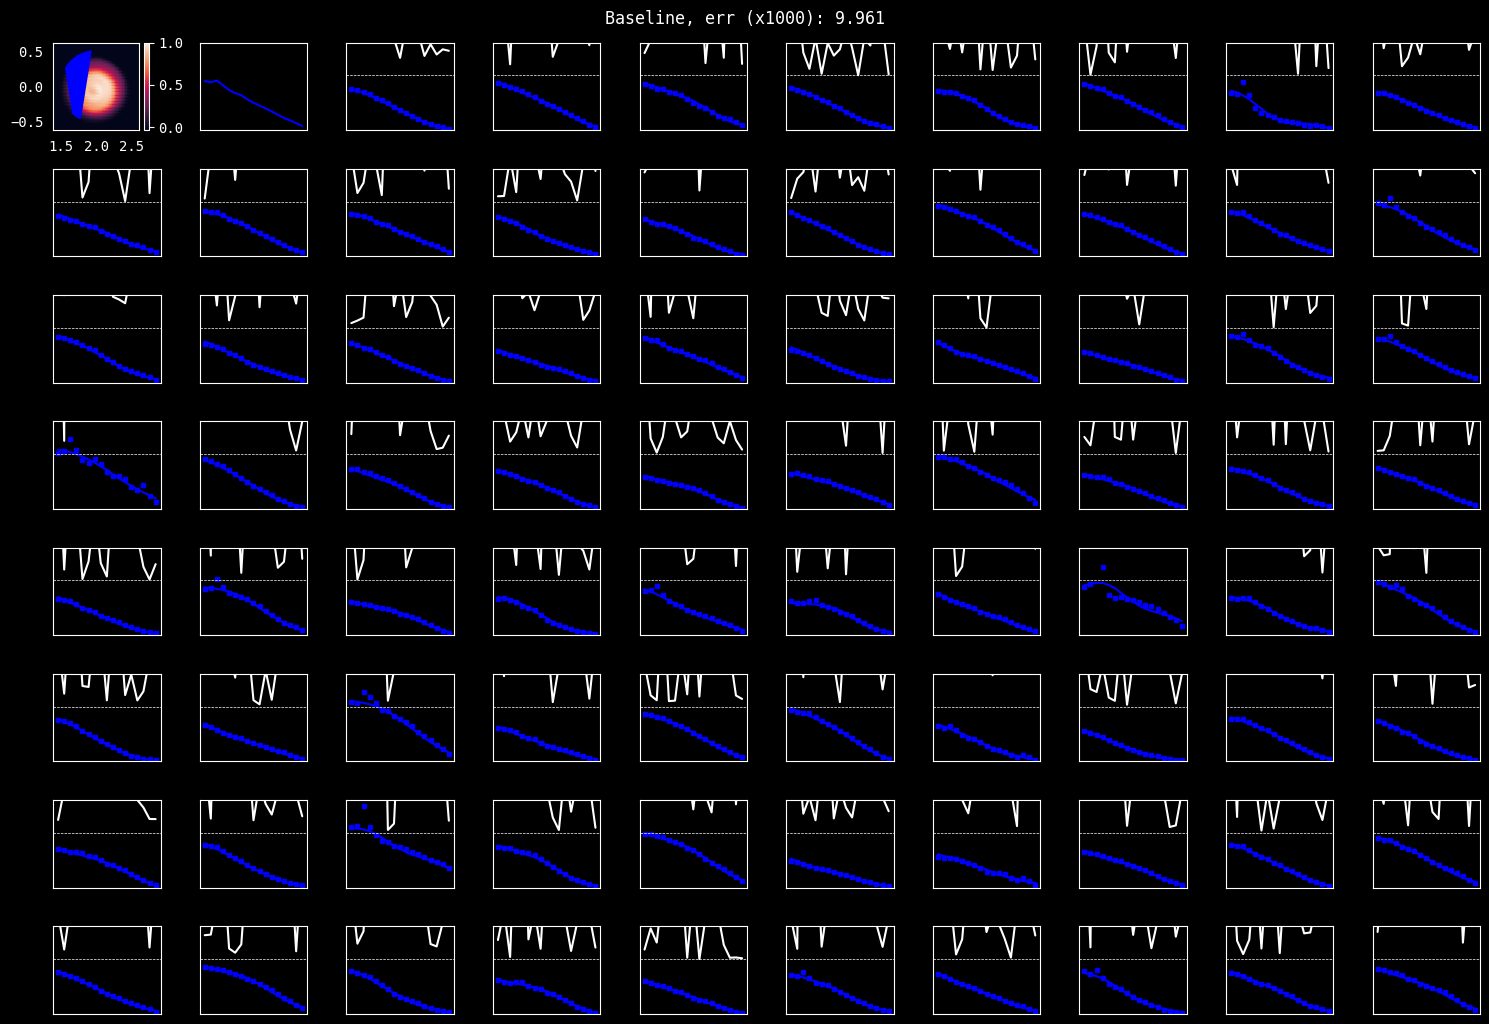

Best error (x1000): 9.882 at (dx, dy): (0.0000, 0.0000), dθ: -0.0087


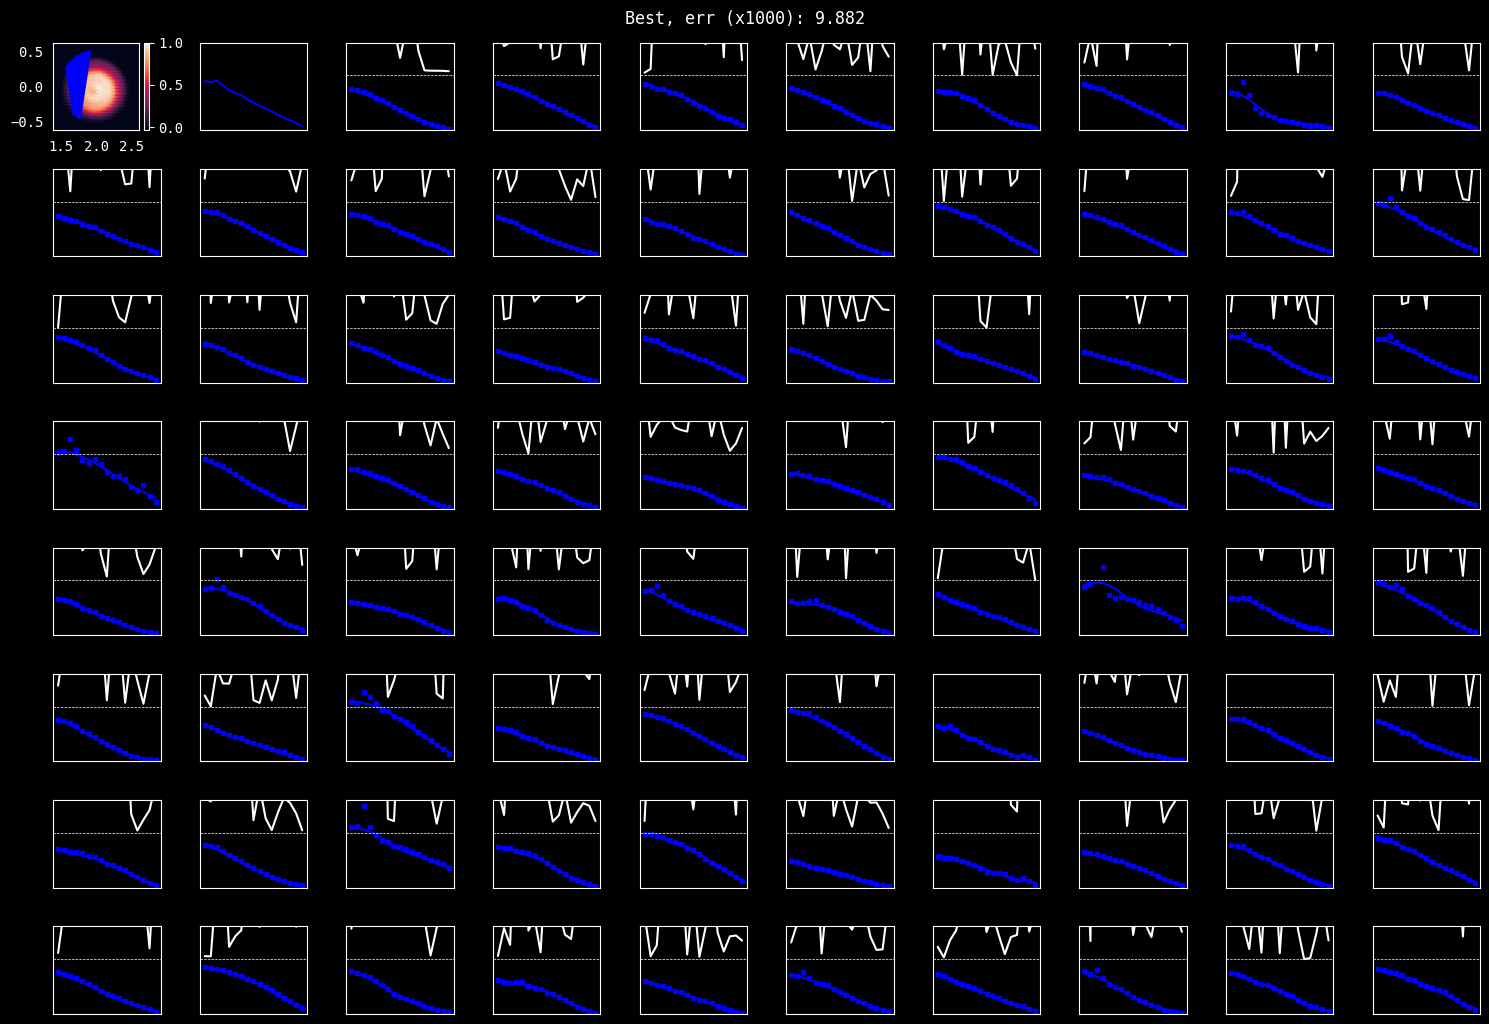

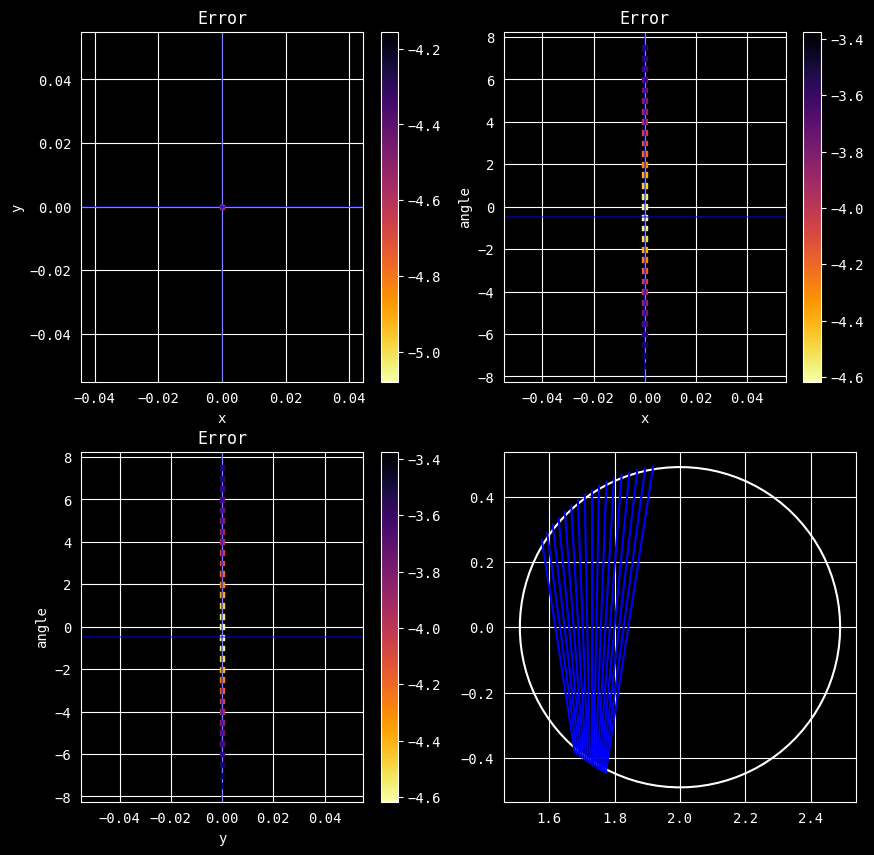

I:1, VDC
Keeping 41455/50000 samples, 82.9%
Weights: [0.834 0.876 0.912 0.943 0.968 0.986 0.996 1.    0.996 0.986 0.968 0.943
 0.912 0.876 0.834 0.788]
Baseline error (x1000): 16.327


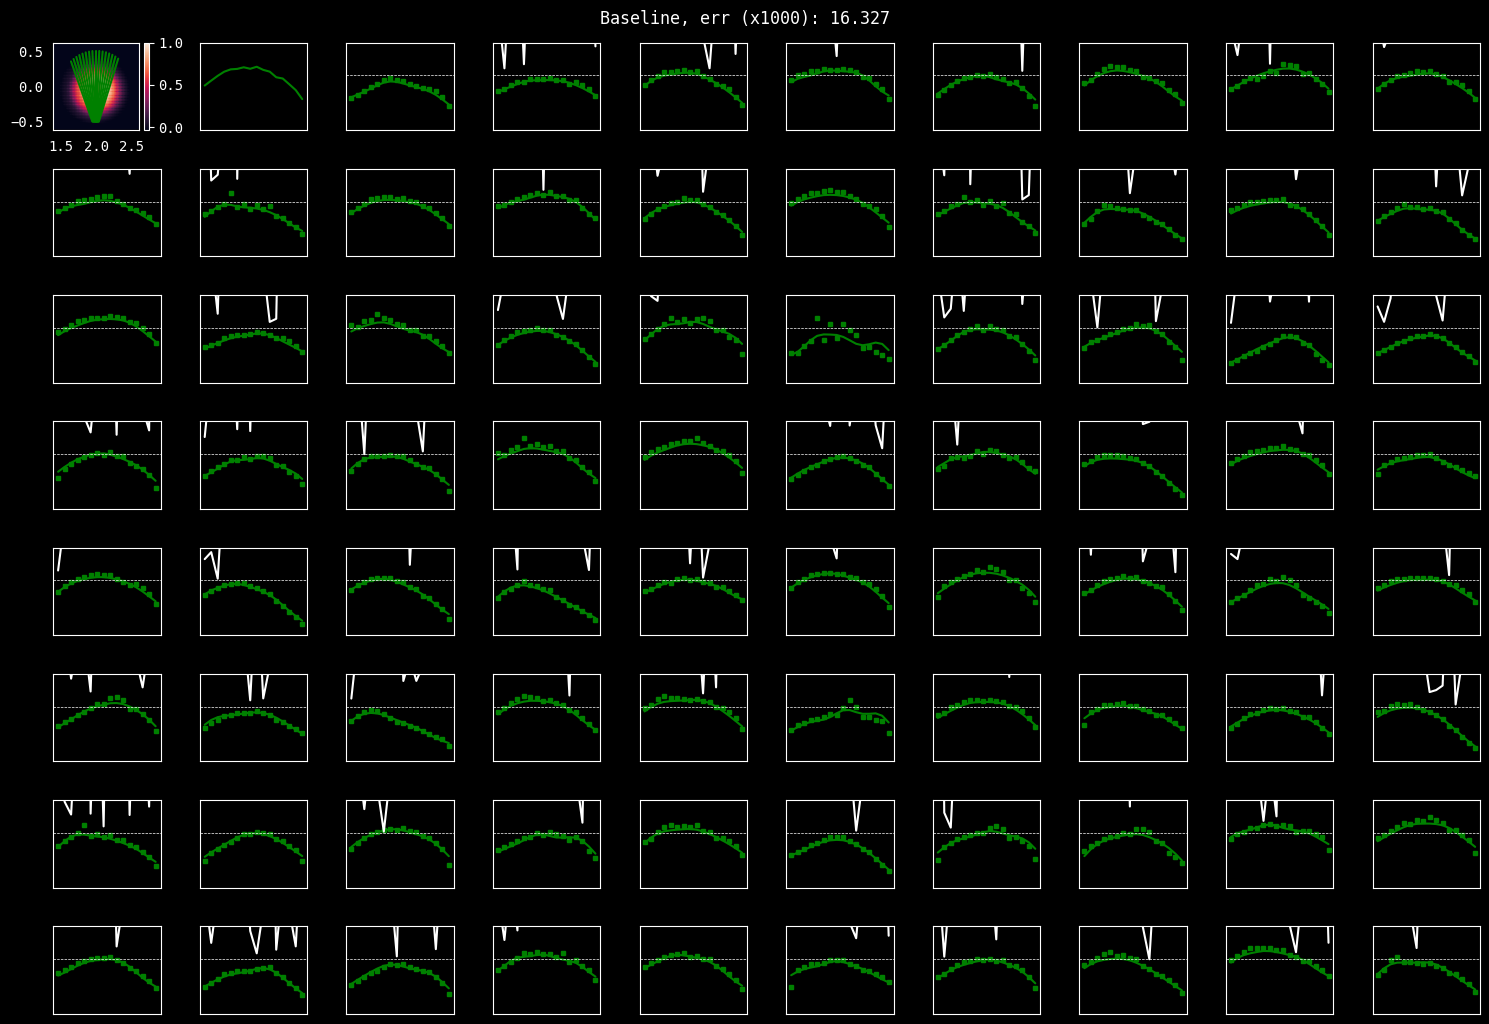

Best error (x1000): 16.145 at (dx, dy): (0.0000, 0.0000), dθ: -0.0175


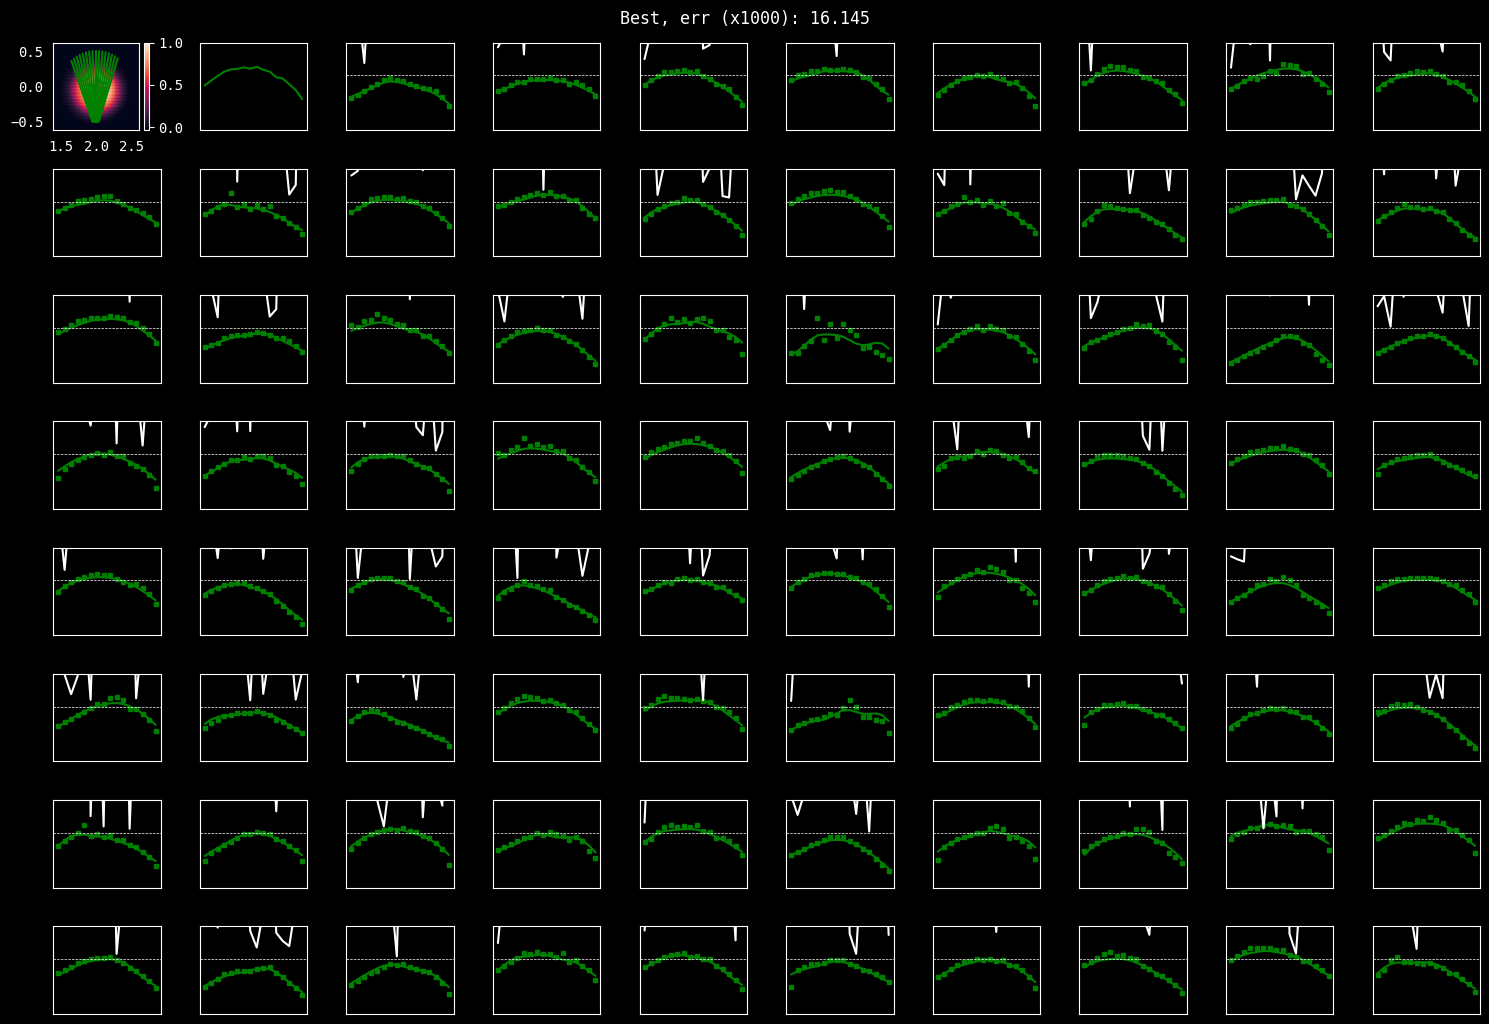

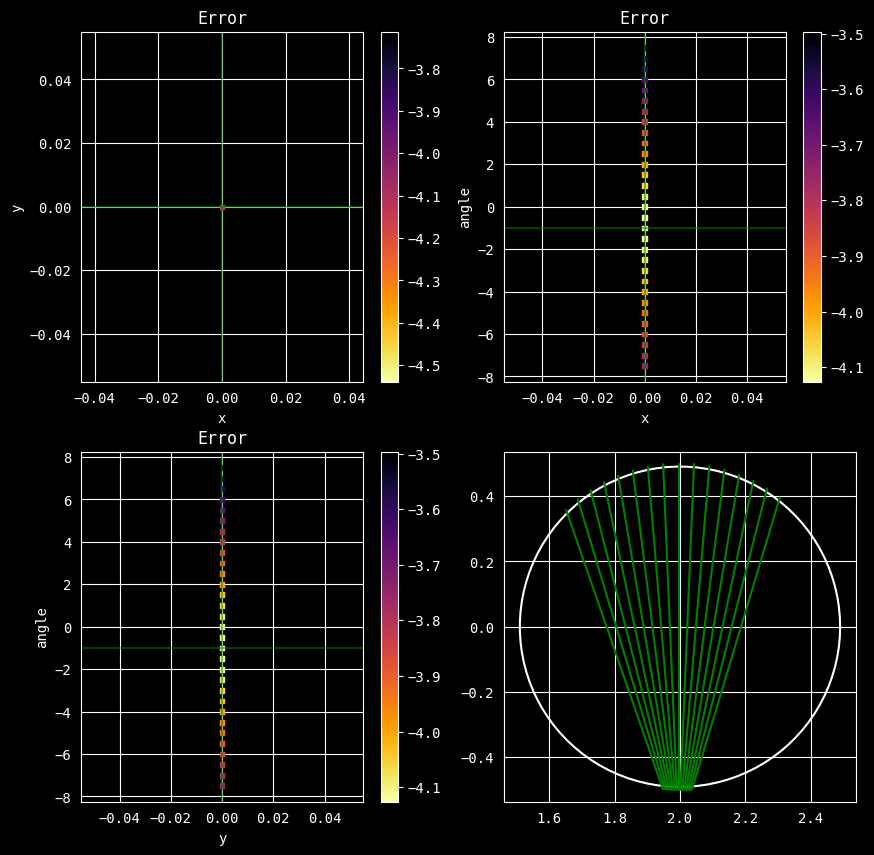

I:2, VDE
Keeping 2121/50000 samples, 4.2%
Weights: [0.801 0.844 0.883 0.918 0.947 0.97  0.986 0.997 1.    0.997 0.986 0.97
 0.947 0.918 0.883 0.844]
Baseline error (x1000): 22.759


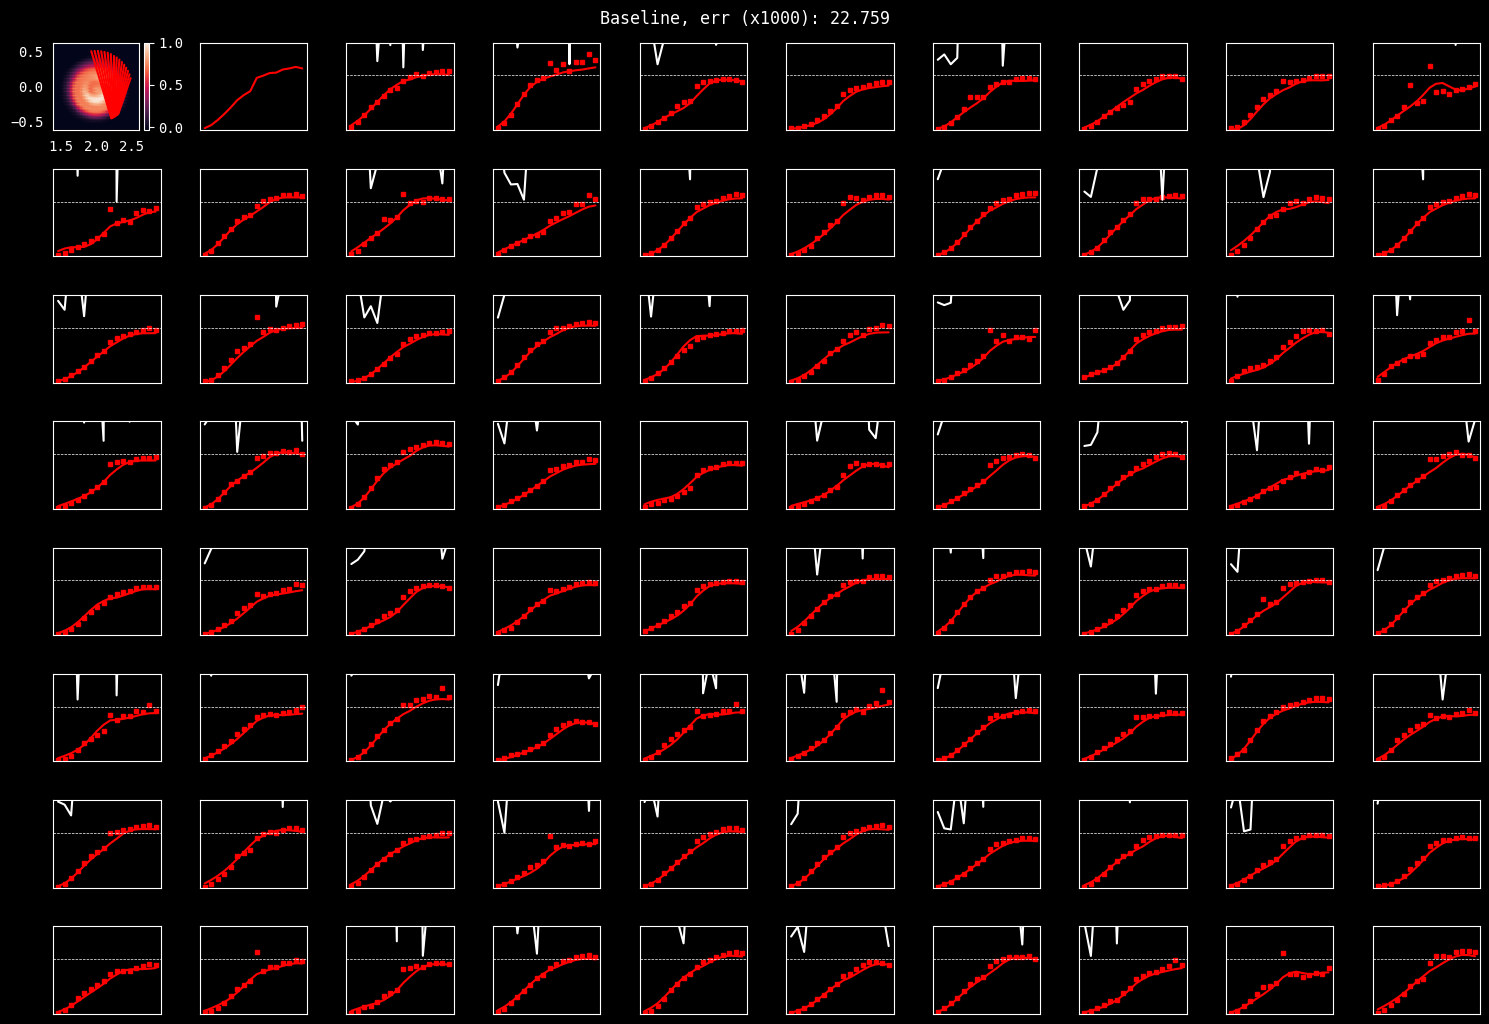

Best error (x1000): 22.759 at (dx, dy): (0.0000, 0.0000), dθ: 0.0000


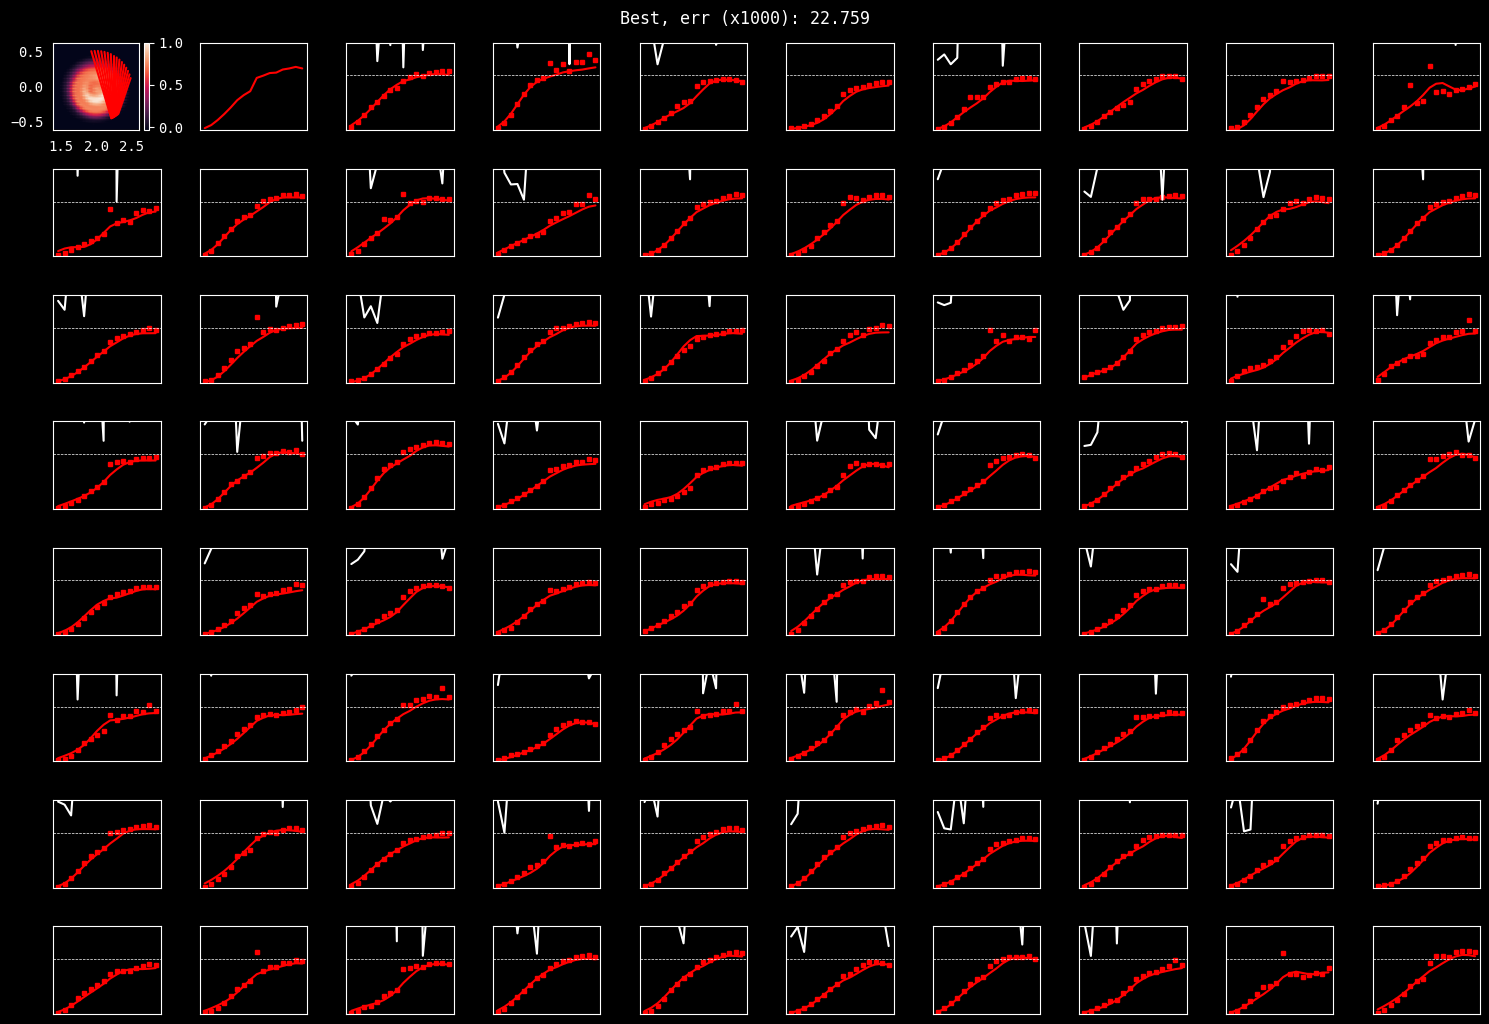

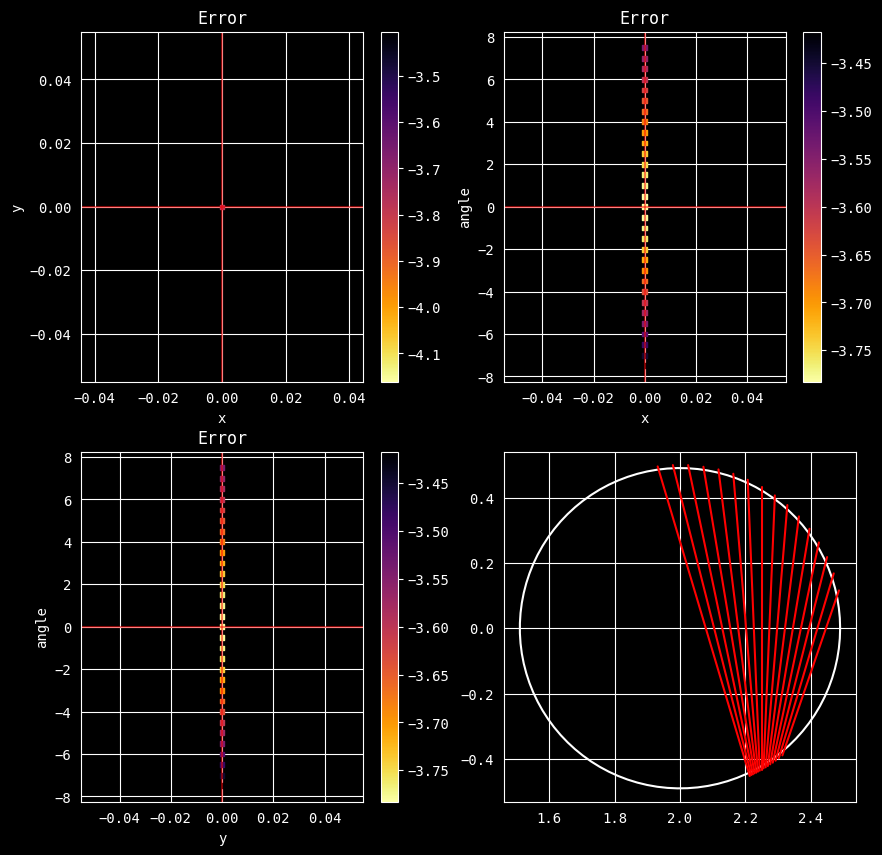

I:3, HOR
Keeping 25027/50000 samples, 50.1%
Weights: [0.374 0.478 0.587 0.694 0.794 0.879 0.945 0.986 1.    0.986 0.945 0.879
 0.794 0.694 0.587 0.478 0.374 0.279 0.197]
Baseline error (x1000): 12.049


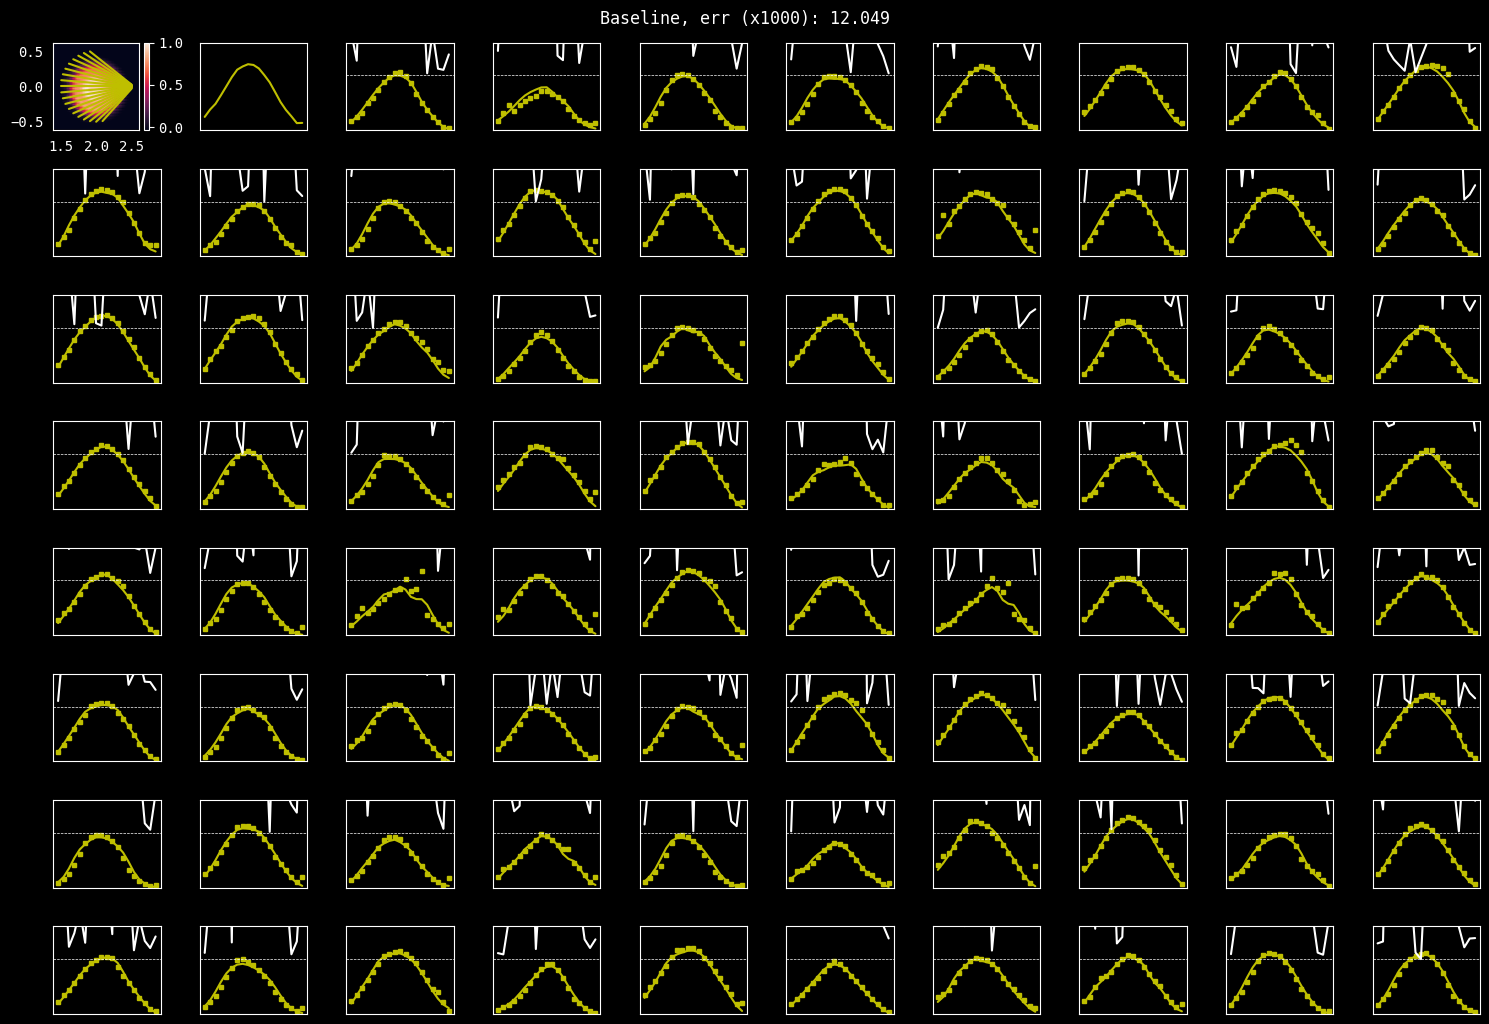

Best error (x1000): 11.998 at (dx, dy): (0.0000, 0.0000), dθ: 0.0087


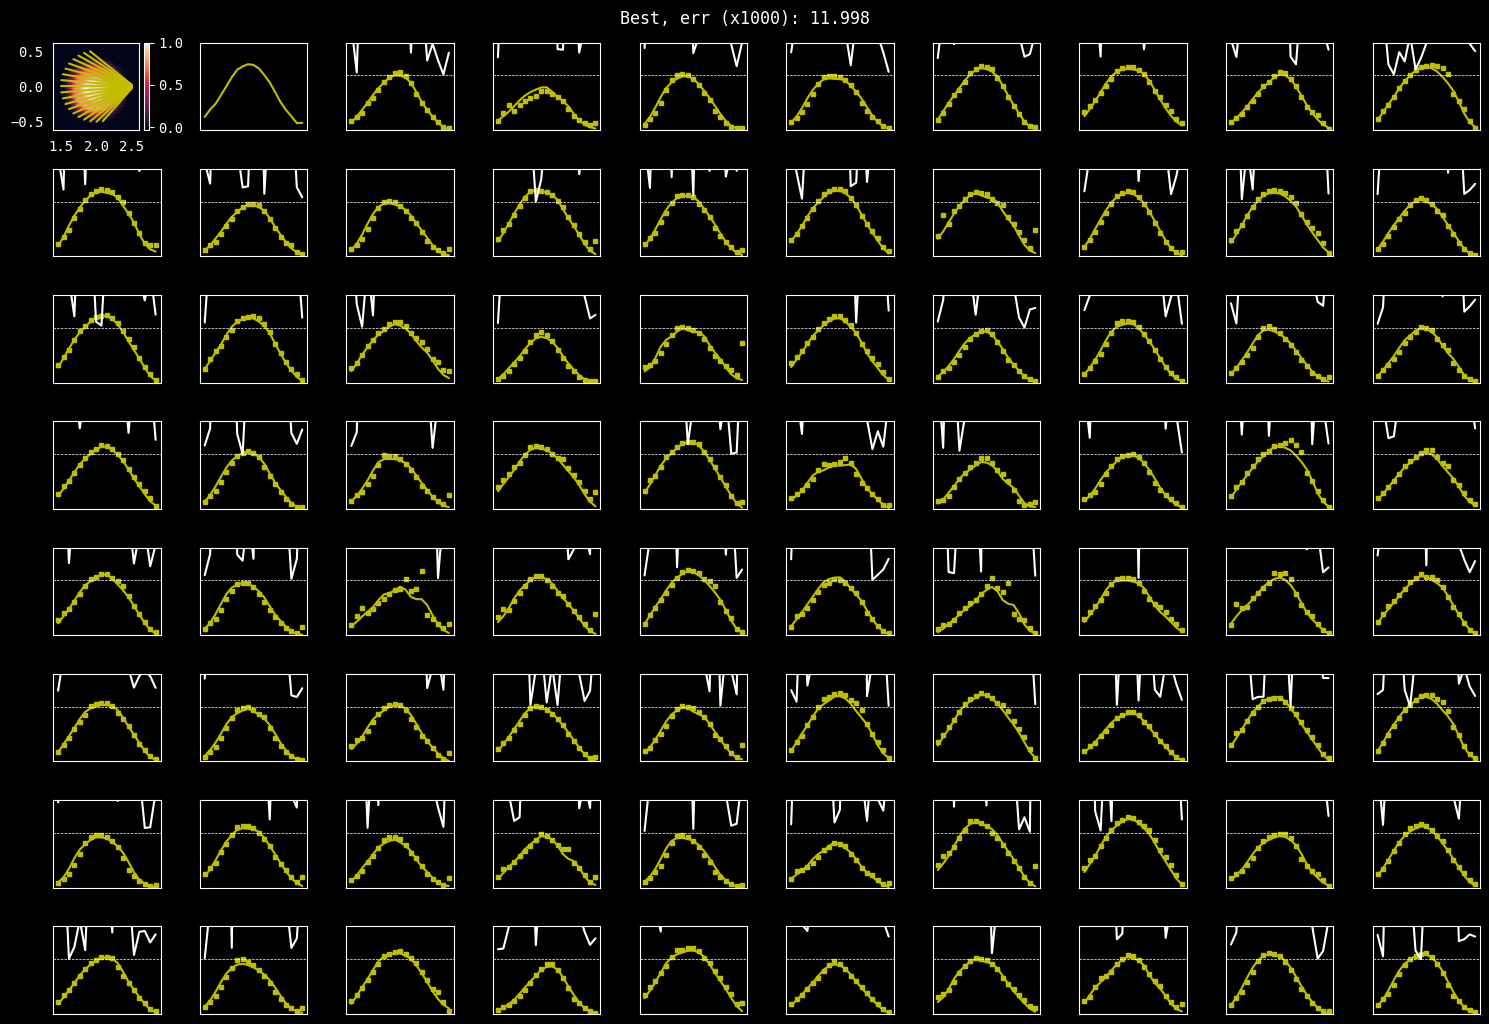

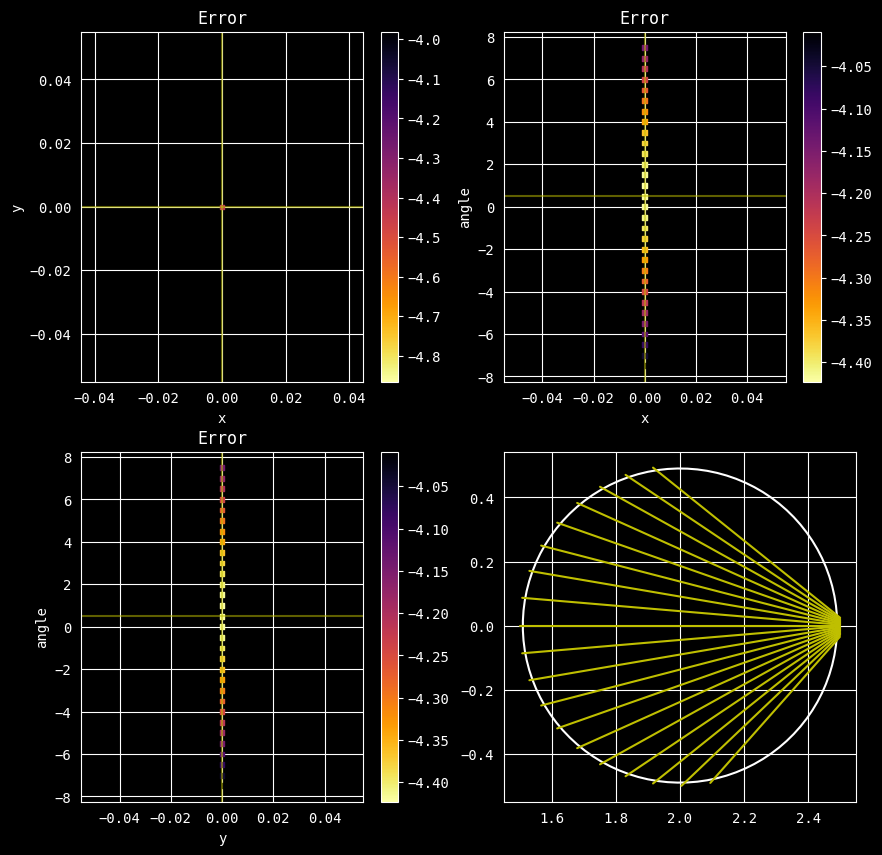

In [5]:
## FILTERING AND TUNING
for I in range(4): # all
# for I in [0]: # VDI
# for I in [1]: # VDC
# for I in [2]: # VDE
# for I in [3]: # HOR
    color, name = RFX_SXR_COLORS[I], RFX_SXR_NAMES[I]
    print(f'============================================================================\nI:{I}, {name}')

    ## filter data
    mins = np.min(SXRS[I], axis=1)
    # itk = np.where(mins > 0.1)[0] # idxs to keep
    itk = np.where(mins > 0.01)[0] # idxs to keep
    # itk = np.arange(len(SXRS[I])) # idxs to keep, all
    print(f'Keeping {len(itk)}/{len(SXRS[I])} samples, {len(itk)/len(SXRS[I])*100:.1f}%')
    emiss = EMISS[itk] # filtered emissivity
    sxr = SXRS[I][itk] # filtered soft x ray

    # get average
    avg = np.mean(sxr, axis=0)

    ## BASELINE (untuned)
    # baseline_err = test_combination(0, 0, 0, emiss, sxr, RFX_SXR_NRAYS[I], RFX_SXR_STARTS[I], RFX_SXR_SPANS[I], RFX_SXR_PINHOLES[I], RFX_SXR_TO_KEEP[I])
    rays, fan, inc_angles = create_rfx_fan(RFX_SXR_NRAYS[I], RFX_SXR_STARTS[I], RFX_SXR_SPANS[I], RFX_SXR_PINHOLES[I], RFX_SXR_TO_KEEP[I], ret_all=True)
    #weight more central values of the sxr
    w = cos(inc_angles)**6
    print(f'Weights: {w}')
    bcsxr = calc_all_sxrs(fan, emiss) # baseline calculated sxr
    assert bcsxr.shape == sxr.shape, f'shapes do not match: {bcsxr.shape} != {sxr.shape}'
    # baseline_err = w*(sxr - bcsxr)**2 # L2
    baseline_err = w*abs(sxr - bcsxr) # L1
    print(f'Baseline error (x1000): {1000*np.mean(baseline_err):.3f}')

    # plot examples 
    plot_examples(emiss, sxr, bcsxr, baseline_err, avg, rays, inc_angles, color, title='Baseline', rows=8, cols=10)

    ## TUNING

    # parameters ranges
    dxs = np.linspace(-dxM, dxM, nx, endpoint=True)
    dys = np.linspace(-dyM, dyM, ny, endpoint=True)
    dθs = np.linspace(-dθM, dθM, nθ, endpoint=True)

    # grids
    xy, yx = np.meshgrid(dxs, dys)
    xa, ax = np.meshgrid(dxs, dθs)
    ya, ay = np.meshgrid(dys, dθs)


    err = np.zeros((nx, ny, nθ)) # initialize errors
    for i, dx in enumerate(tqdm(dxs, leave=False)):
        for j, dy in enumerate(dys):
            for k, dθ in enumerate(dθs):
                ph = RFX_SXR_PINHOLES[I] + np.array([dx, dy])
                start_θ, span_θ = RFX_SXR_STARTS[I] - dθ/2, RFX_SXR_SPANS[I] + dθ
                rays, fan, _ = create_rfx_fan(RFX_SXR_NRAYS[I], start_θ, span_θ, ph, RFX_SXR_TO_KEEP[I], ret_all=True)
                csxr = calc_all_sxrs(fan, emiss)

                # err[i,j,k] = np.mean(w*(sxr - csxr)**2) # L2
                err[i,j,k] = np.mean(w*abs(sxr - csxr)) # L1

    # find the best
    best_dx = np.argmin(np.min(err, axis=(1,2))) # best idx in dx
    best_dy = np.argmin(np.min(err, axis=(0,2))) # best idx in dy
    best_dθ = np.argmin(np.min(err, axis=(0,1))) # best idx in dθ
    best_err = err[best_dx, best_dy, best_dθ]
    best_dx, best_dy, best_dθ = dxs[best_dx], dys[best_dy], dθs[best_dθ]
    print(f'Best error (x1000): {1000*best_err:.3f} at (dx, dy): ({best_dx:.4f}, {best_dy:.4f}), dθ: {best_dθ:.4f}')

    # plot best combination
    rays, fan, inc_angles = create_rfx_fan(RFX_SXR_NRAYS[I], RFX_SXR_STARTS[I]-best_dθ/2, RFX_SXR_SPANS[I]+best_dθ, RFX_SXR_PINHOLES[I]+np.array([best_dx, best_dy]), RFX_SXR_TO_KEEP[I], ret_all=True)
    csxr = calc_all_sxrs(fan, emiss)
    # err_s = w*(sxr - csxr)**2 # L2
    err_s = w*abs(sxr - csxr) # L1
    plot_examples(emiss, sxr, csxr, err_s, avg, rays, inc_angles, color, title='Best', rows=8, cols=10)

    cmap = 'inferno_r'
    mark = 's'
    # ph_x, ph_y = RFX_SXR_PINHOLES[I][0], RFX_SXR_PINHOLES[I][1]

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.axvline(best_dx, color=color, alpha=0.5)
    plt.axhline(best_dy, color=color, alpha=0.5)
    # plt.scatter(ph_x+xy, ph_y+yx, c=log(err.min(axis=2)), s=12, marker=mark, cmap=cmap)
    plt.scatter(xy, yx, c=log(err.min(axis=2)), s=12, marker=mark, cmap=cmap)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Error')
    plt.axis('equal')

    #plot x / angle
    plt.subplot(2, 2, 2)
    plt.axvline(best_dx, color=color, alpha=0.5)
    plt.axhline(np.rad2deg(best_dθ), color=color, alpha=0.5)
    # plt.scatter(ph_x+xa, np.rad2deg(ax), c=log(err.min(axis=1)), s=12, marker=mark, cmap=cmap)
    plt.scatter(xa, np.rad2deg(ax), c=log(err.min(axis=1)), s=12, marker=mark, cmap=cmap)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('angle')
    plt.title('Error')

    #plot y / angle
    plt.subplot(2, 2, 3)
    plt.axvline(best_dy, color=color, alpha=0.5)
    plt.axhline(np.rad2deg(best_dθ), color=color, alpha=0.5)
    # plt.scatter(ph_y+ya, np.rad2deg(ay), c=log(err.min(axis=0)), s=12, marker=mark, cmap=cmap)
    plt.scatter(ya, np.rad2deg(ay), c=log(err.min(axis=0)), s=12, marker=mark, cmap=cmap)
    plt.colorbar()
    plt.xlabel('y')
    plt.ylabel('angle')
    plt.title('Error')

    # plot fw + rays
    plt.subplot(2, 2, 4)
    plt.plot(FW[:,0], FW[:,1], 'w-') # plot first wall
    for r in rays: plt.plot(r[:,0], r[:,1], f'{color}-')
    plt.axis('equal')
    plt.show()
    plt.close()